In [64]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.optimizers import SGD, Adam

# Data Pre-processing
Abbiamo pre-processato i dati andando ad eliminare i primi 2 secondi di dati in quanto abbiamo ritenuto non fossero direttamente collegati all'attivitá di estrazione o riposizionamento del telefono dalla tasca. 
Abbiamo inoltre sostituito la label con un formato numerico, piú adatto alla rete neurale rispetto alla stringa, formato piú human-readable.

In [67]:
accelerometer = pd.read_csv("SensorData_Acc_0.csv")
#rotation = pd.read_csv("SensorData_Rot_0.csv")

del accelerometer["Unnamed: 5"]

accelerometer.columns = ["ax", "ay", "az", "timestamp", "label"]
accelerometer.index = accelerometer["timestamp"]

#rotation.columns = ["rx", "ry", "rz", "timestamp", "label"]
#rotation.index = rotation["timestamp"]

#accelerometer.join(rotation, lsuffix='_caller', rsuffix='_other')

# 50 hz sampling rate, 600 sample/seconds, discard first two seconds of data
N_FIRST = 600 * 2
accelerometer = accelerometer.iloc[N_FIRST: , :]

#rotation = rotation.iloc[N_FIRST: , :]

# Number of rows to drop
N_LAST = 600
 
# Removing last n rows
accelerometer = accelerometer.iloc[:-N_LAST]

print(accelerometer.shape)

mapping = {'PICKUP': 1, 'PUTDOWN': 2, 'OTHER': 3}
accelerometer.replace({'label': mapping})

accelerometer.label = [mapping[item] for item in accelerometer.label]

print(accelerometer)

training_data, testing_data = train_test_split(accelerometer, test_size=0.25, random_state=25)

training_labels = training_data["label"]
del training_data["label"]

testing_labels = testing_data["label"]
del testing_data["label"]

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

print(training_data)

(9517, 5)
                 ax     ay     az     timestamp  label
timestamp                                             
9.845011e+11  1.271  2.204  7.388  9.845011e+11      2
9.845111e+11  1.539  2.232  7.024  9.845111e+11      2
9.845211e+11  1.923  2.468  6.737  9.845211e+11      2
9.845312e+11  2.341  2.649  5.985  9.845312e+11      2
9.845411e+11  2.777  2.787  5.001  9.845411e+11      2
...             ...    ...    ...           ...    ...
1.107478e+12 -3.737 -7.099  2.281  1.107478e+12      2
1.107487e+12 -3.882 -6.757  2.769  1.107487e+12      2
1.107498e+12 -4.542 -5.993  2.350  1.107498e+12      2
1.107507e+12 -5.490 -3.869  0.863  1.107507e+12      2
1.107518e+12 -5.803 -0.619 -0.868  1.107518e+12      2

[9517 rows x 5 columns]
No. of training examples: 7137
No. of testing examples: 2380
                  ax      ay      az     timestamp
timestamp                                         
1.068132e+12 -13.000  -2.423   2.482  1.068132e+12
1.011251e+12  -1.051   3.944   6.617

# Costruzione modello
Abbiamo quindi costruito un CNN utilizzando il modulo Tensorflow con diversi livelli.


In [68]:
model = models.Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(100, activation="sigmoid"))
model.add(layers.Dropout(0.25))
model.add(layers.BatchNormalization())

model.add(layers.Dense(4, activation="sigmoid"))

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(training_data, training_labels, epochs=10, validation_data=(testing_data, testing_labels))
model.save(".")

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


224/224 [==============================] - 2s 5ms/step - loss: 0.8661 - accuracy: 0.7088 - val_loss: 0.6503 - val_accuracy: 0.8097
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


224/224 [==============================] - 1s 3ms/step - loss: 0.6201 - accuracy: 0.8251 - val_loss: 0.6336 - val_accuracy: 0.8097
Epoch 3/10
224/224 [==============================] - 1s 3ms/step - loss: 0.5932 - accuracy: 0.8251 - val_loss: 0.6268 - val_accuracy: 0.8097
Epoch 4/10
224/224 [==============================] - 1s 2ms/step - loss: 0.5878 - accuracy: 0.8251 - val_loss: 0.6225 - val_accuracy: 0.8097
Epoch 5/10
224/224 [==============================] - 1s 3ms/step - loss: 0.5848 - accuracy: 0.8251 - val_loss: 0.6229 - val_accuracy: 0.8097
Epoch 6/10
224/224 [==============================] - 1s 3ms/step - loss: 0.5843 - accuracy: 0.8251 - val_loss: 0.6231 - val_accuracy: 0.8097
Epoch 7/10
224/224 [==============================] - 1s 2ms/step - loss: 0.5841 - accuracy: 0.8251 - val_loss: 0.6249 - val_accuracy: 0.8097
Epoch 8/10
224/224 [==============================] - 1s 2ms/step - loss: 0.5821 - accuracy: 0.8251 - val_loss: 0.6248 - val_accuracy: 0.8097
Epoch 9/10
224/22

75/75 - 0s - loss: 0.6218 - accuracy: 0.8097 - 100ms/epoch - 1ms/step


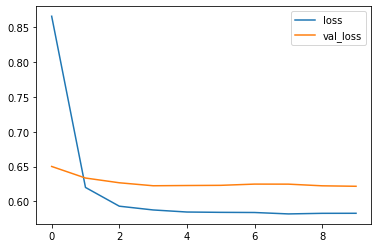

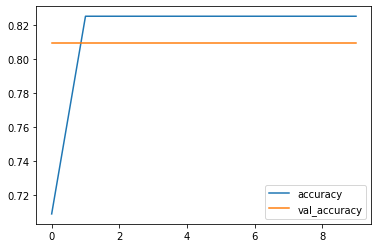

In [71]:
test_loss, test_acc = model.evaluate(testing_data,  testing_labels, verbose=2)

metrics_df = pd.DataFrame(history.history)
metrics_df[["loss","val_loss"]].plot();
metrics_df[["accuracy","val_accuracy"]].plot();


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(".") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)